# 📊 Stock ML Insights Report  
### Predicting Stock Prices and Backtesting Strategies with Machine Learning

Author: Tarun Yadav  
University: Delhi Technological University  
Project Type: ML + Finance (Stock Market Prediction)  
Language: Python   

---

## 📘 Overview
This notebook demonstrates three different approaches for analyzing and predicting stock price movements using machine learning and technical analysis.

### 🔍 Case 1: LSTM Stock Price Prediction
Predicts the next-day closing price of a stock using historical data and Long Short-Term Memory (LSTM) neural networks.

### ⚙️ Case 2: Moving Average (MA) Crossover Strategy
Implements a traditional MA9/MA21 crossover strategy and simulates trading performance.

### 🧩 Case 3: Technical Indicators + ML Model
Combines multiple indicators (RSI, MACD, Bollinger Bands, ATR) with LSTM to improve prediction accuracy and decision-making.

---

## 🧰 Libraries Used
- **yFinance** – fetch stock market data  
- **Pandas, NumPy** – data manipulation  
- **Matplotlib** – data visualization  
- **Scikit-learn** – data scaling, metrics  
- **TensorFlow / Keras** – neural network modeling  

---



## 🔧 Step 1: Install and Import Required Libraries
This section sets up the environment, installs required packages, and imports all the necessary libraries for data analysis, visualization, and machine learning.


In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', None)
print("Imports OK — pandas:", pd.__version__)

Imports OK — pandas: 2.2.2


## 📈 Step 2: Fetch Stock Data from Yahoo Finance

Here we download historical stock data using the `yfinance` library.  
We use **Reliance Industries (RELIANCE.NS)** as an example, but this can be replaced with any ticker symbol.


In [ ]:
TICKER = "RELIANCE.NS"
START = "2023-01-01"
END = datetime.now().strftime("%Y-%m-%d")

# Folder to save raw/clean CSVs
DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)

print("Ticker:", TICKER)
print("Date range:", START, "to", END)
print("Data folder:", DATA_DIR)


Ticker: RELIANCE.NS
Date range: 2023-01-01 to 2025-11-01
Data folder: data


In [ ]:
def fetch_stock_data(ticker: str, start: str, end: str, auto_adjust: bool = True) -> pd.DataFrame:

    stock = yf.Ticker(ticker)
    # use history to preserve original index -> price columns
    df = stock.history(start=start, end=end, auto_adjust=auto_adjust)
    if df is None or df.empty:
        raise ValueError(f"No data fetched for {ticker} in range {start}:{end}")
    df = df.reset_index()
    # Standardize column names to lower-case single-word names
    df = df.rename(columns={
        'Date': 'date', 'Open': 'open', 'High': 'high',
        'Low': 'low', 'Close': 'close', 'Volume': 'volume'
    })
    df['ticker'] = ticker
    # keep only standard columns
    df = df[['date','open','high','low','close','volume','ticker']]
    return df


# Quick test (single ticker):
df = fetch_stock_data(TICKER, START, END)
print("Fetched rows:", len(df))
display(df.head())


Fetched rows: 699


,date,open,high,low,close,volume,ticker
0,2023-01-02 00:00:00+05:30,1164.066352,1177.304802,1163.244669,1175.889648,5316175,RELIANCE.NS
1,2023-01-03 00:00:00+05:30,1170.936659,1174.565828,1163.062148,1167.284668,7658932,RELIANCE.NS
2,2023-01-04 00:00:00+05:30,1167.261851,1169.110728,1147.632506,1149.709595,9264891,RELIANCE.NS
3,2023-01-05 00:00:00+05:30,1151.969321,1157.858149,1143.067616,1147.655396,13637099,RELIANCE.NS
4,2023-01-06 00:00:00+05:30,1153.407240,1163.130627,1149.595501,1158.086304,6349597,RELIANCE.NS


# 🧠 Case 1: LSTM Model — Predicting Next Day Price

In this case, we use a **Long Short-Term Memory (LSTM)** neural network to predict the next day's closing price.

### Workflow:
1. Fetch and preprocess stock data  
2. Split into training and validation sets  
3. Scale data and create input sequences (60-day lookback)  
4. Build and train the LSTM model  
5. Predict prices and visualize performance  
6. Simulate a simple trading strategy using predictions


In [ ]:
df['date'] = pd.to_datetime(df['date']).dt.normalize()


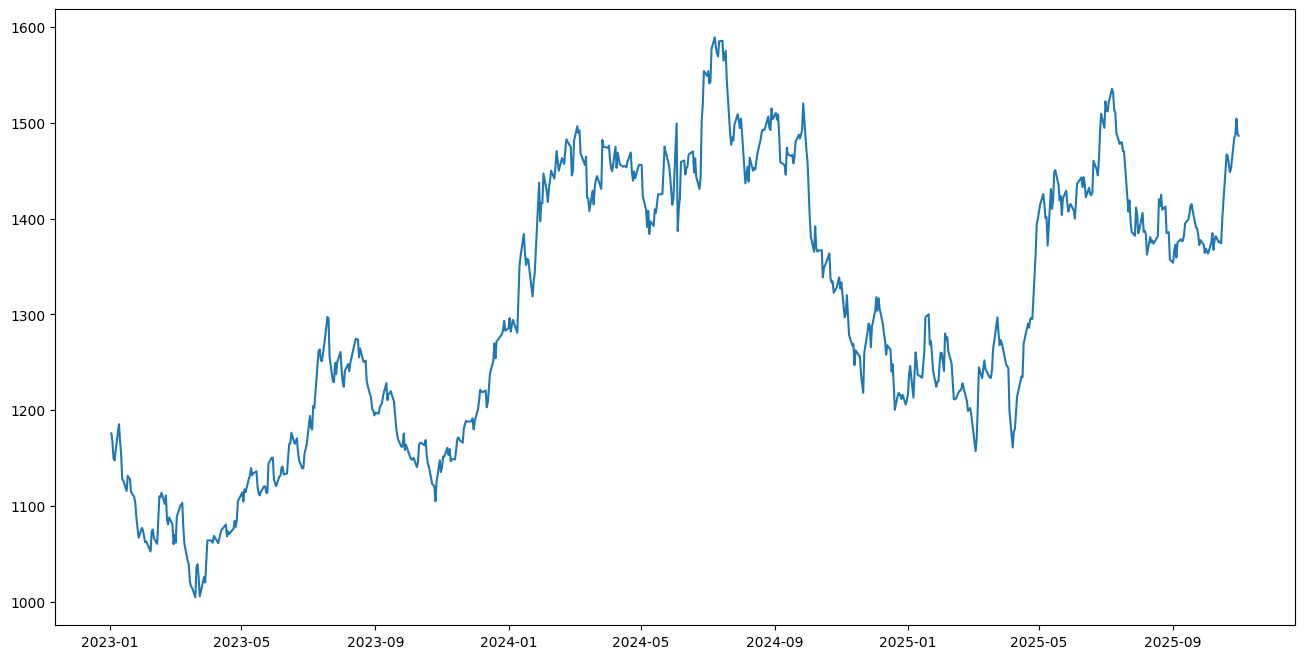

In [ ]:
df["date"] = pd.to_datetime(df.date, format="%Y-%m-%d")
df.index = df['date']

plt.figure(figsize=(16,8))
plt.plot(df["close"], label='Close Price history')


In [ ]:
data = df.sort_index(ascending=True, axis=0)
new_dataset = pd.DataFrame(index=range(0, len(df)), columns=['Date', 'Close'])

new_dataset = data[['date', 'close']].reset_index(drop=True)


In [ ]:
new_dataset.index = new_dataset['date']
new_dataset.drop("date", axis=1, inplace=True)

# Split before scaling to prevent data leakage
train_data = new_dataset[:559]
valid_data = new_dataset[559:]

# Scale only on train data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train_data = scaler.fit_transform(train_data)

x_train_data, y_train_data = [], []

for i in range(60, len(scaled_train_data)):
    x_train_data.append(scaled_train_data[i-60:i, 0])
    y_train_data.append(scaled_train_data[i, 0])

x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 1))


In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=150, return_sequences=True, input_shape=(x_train_data.shape[1], 1)))
lstm_model.add(LSTM(units=150))
lstm_model.add(Dense(1))

inputs_data = new_dataset[len(new_dataset) - len(valid_data) - 60:].values
inputs_data = inputs_data.reshape(-1, 1)
inputs_data = scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(x_train_data, y_train_data, epochs=5, batch_size=2, verbose=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Epoch 1/5
250/250 - 23s - 92ms/step - loss: 0.0090
Epoch 2/5
250/250 - 23s - 92ms/step - loss: 0.0038
Epoch 3/5
250/250 - 37s - 147ms/step - loss: 0.0028
Epoch 4/5
250/250 - 21s - 85ms/step - loss: 0.0027
Epoch 5/5
250/250 - 18s - 73ms/step - loss: 0.0022


In [ ]:
X_test = []
for i in range(60, inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_closing_price = lstm_model.predict(X_test)
predicted_closing_price = scaler.inverse_transform(predicted_closing_price)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step


In [ ]:
lstm_model.save("saved_model.h5")

/tmp/ipython-input-1896311740.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions'] = predicted_closing_price.ravel()


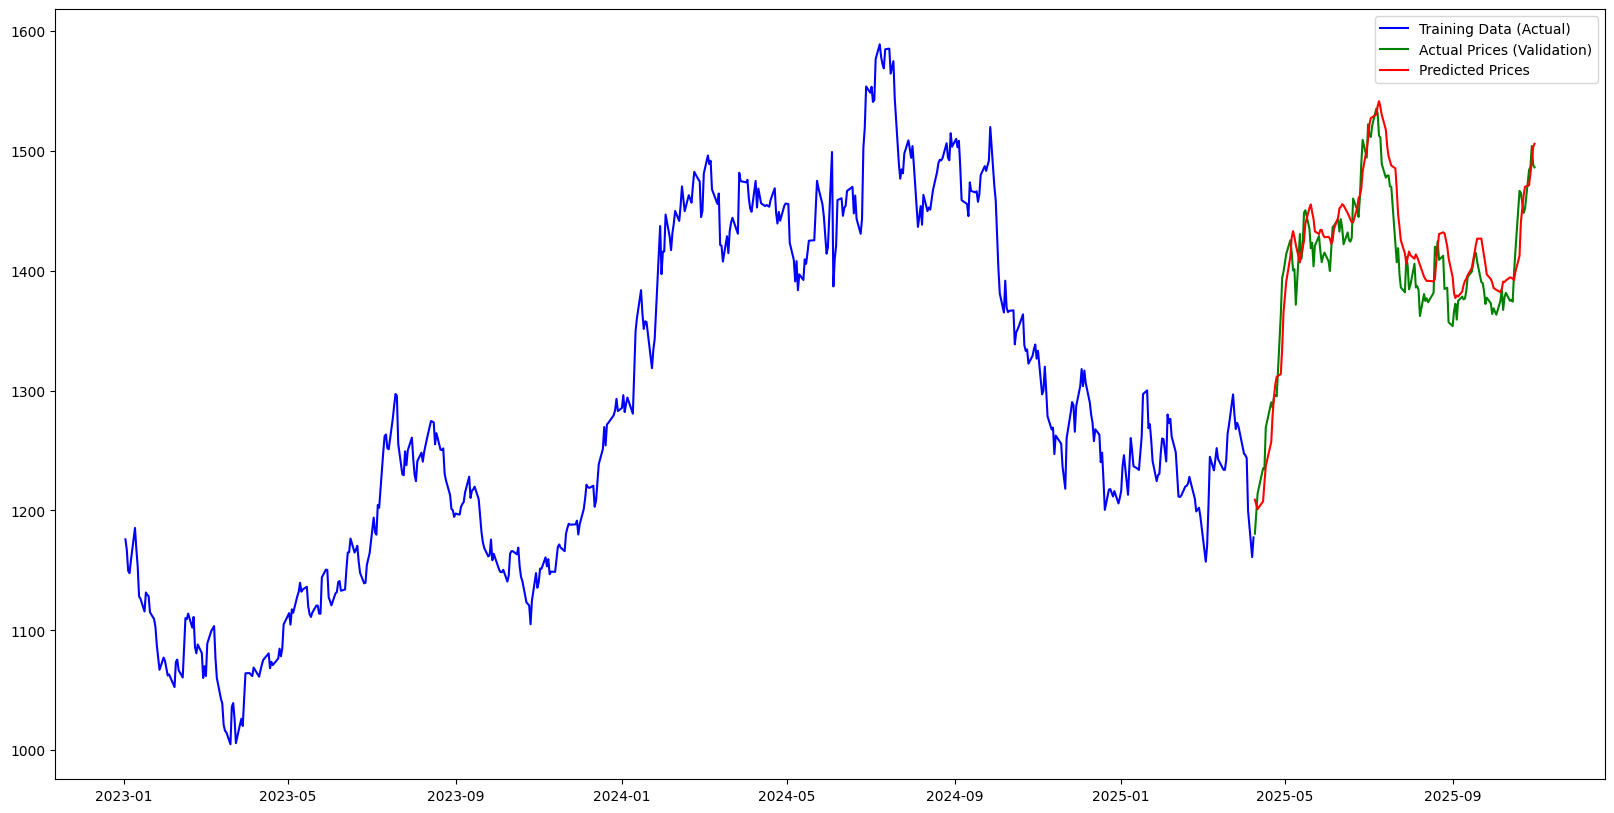

In [ ]:
train_data = new_dataset[:559]
valid_data = new_dataset[559:]
valid_data['Predictions'] = predicted_closing_price.ravel()
plt.plot(train_data["close"], label="Training Data (Actual)", color='blue')   # Blue for training data
plt.plot(valid_data["close"], label="Actual Prices (Validation)", color='green')   # Green for actual validation
plt.plot(valid_data["Predictions"], label="Predicted Prices", color='red')   # Red for predicted
plt.legend()


### 📊 Model Evaluation and Visualization
We compare actual vs predicted prices and simulate a basic buy/sell strategy.


In [ ]:
# Demo Trading Simulation using predicted prices
initial_capital = 10000
cash = initial_capital
shares = 0

actual_prices = new_dataset['close'].values[559:]
pred_prices = predicted_closing_price.ravel()

# Trading history
trades = []

# Simple strategy:
# Buy if predicted price tomorrow > today's actual price
# Sell if predicted price tomorrow <= today's actual price
for i in range(len(pred_prices)-1):
    # Buy signal
    if pred_prices[i+1] > actual_prices[i]:
        if cash > 0:
            shares = cash / actual_prices[i]
            cash = 0
            trades.append((new_dataset.index[559+i], 'BUY', actual_prices[i], shares))
    # Sell signal
    else:
        if shares > 0:
            cash = shares * actual_prices[i]
            trades.append((new_dataset.index[559+i], 'SELL', actual_prices[i], shares))
            shares = 0

if shares > 0:
    cash = shares * actual_prices[-1]
    trades.append((new_dataset.index[-1], 'SELL', actual_prices[-1], shares))
    shares = 0

# Calculate returns
profit = cash - initial_capital
returns_pct = (profit / initial_capital) * 100

print(f"Initial Capital: ₹{initial_capital}")
print(f"Final Capital: ₹{cash:.2f}")
print(f"Profit/Loss: ₹{profit:.2f}")
print(f"Return: {returns_pct:.2f}%")

# Display trade history
trade_df = pd.DataFrame(trades, columns=['Date', 'Action', 'Price', 'Shares'])
display(trade_df)


Initial Capital: ₹10000
Final Capital: ₹11826.99
Profit/Loss: ₹1826.99
Return: 18.27%


,Date,Action,Price,Shares
0,2025-04-09 00:00:00+05:30,BUY,1180.634644,8.470021
1,2025-04-11 00:00:00+05:30,SELL,1214.100952,8.470021
2,2025-04-16 00:00:00+05:30,BUY,1234.370117,8.330938
3,2025-04-17 00:00:00+05:30,SELL,1269.430054,8.330938
4,2025-04-22 00:00:00+05:30,BUY,1286.063599,8.223188
5,2025-04-28 00:00:00+05:30,SELL,1363.354980,8.223188
6,2025-05-05 00:00:00+05:30,BUY,1425.606323,7.864109
7,2025-05-12 00:00:00+05:30,SELL,1430.785522,7.864109
8,2025-05-13 00:00:00+05:30,BUY,1410.068237,7.979652
9,2025-05-15 00:00:00+05:30,SELL,1448.415161,7.979652


# ⚙️ Case 2: MA Crossover Strategy

In this strategy, we use two simple moving averages (MA9 and MA21) to generate trading signals:
- **BUY** when MA9 crosses above MA21  
- **SELL** when MA9 crosses below MA21  

We also compute the RSI (14-day) to support decision-making and simulate a backtest of this strategy.





In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

TICKER = "RELIANCE.NS"
START = "2023-01-01"

# Fetch data
df = yf.download(TICKER, start=START)
df = df[['Open','High','Low','Close','Volume']]
df.rename(columns={'Close':'close','Open':'open','High':'high','Low':'low','Volume':'volume'}, inplace=True)
df.head()


/tmp/ipython-input-2572879803.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START)
[*********************100%***********************]  1 of 1 completed


Price,open,high,low,close,volume
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
Date,,,,,
2023-01-02,1164.066352,1177.304802,1163.244669,1175.889648,5316175
2023-01-03,1170.936659,1174.565828,1163.062148,1167.284668,7658932
2023-01-04,1167.261851,1169.110728,1147.632506,1149.709595,9264891
2023-01-05,1151.969199,1157.858026,1143.067494,1147.655273,13637099
2023-01-06,1153.407240,1163.130627,1149.595501,1158.086304,6349597


In [ ]:
# Moving Averages
df['MA9'] = df['close'].rolling(window=9).mean()
df['MA21'] = df['close'].rolling(window=21).mean()

# RSI (14-day)
delta = df['close'].diff()
up = delta.clip(lower=0)
down = -1*delta.clip(upper=0)
roll_up = up.rolling(14).mean()
roll_down = down.rolling(14).mean()
RS = roll_up / roll_down
df['RSI_14'] = 100 - (100 / (1 + RS))

df = df.dropna()
df.tail()


Price,open,high,low,close,volume,MA9,MA21,RSI_14
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,,,
Date,,,,,,,,
2025-10-27,1463.000000,1485.000000,1458.000000,1484.099976,14113867,1431.266683,1398.190488,77.648255
2025-10-28,1484.099976,1492.000000,1477.599976,1486.900024,17631577,1443.600016,1403.642869,76.826068
2025-10-29,1490.000000,1508.300049,1488.099976,1504.199951,11884745,1458.033339,1409.671439,85.962158
2025-10-30,1500.000000,1503.099976,1484.000000,1488.500000,9318663,1468.055556,1415.180961,78.312043
2025-10-31,1490.400024,1497.500000,1482.300049,1486.400024,8758053,1475.788886,1421.009533,77.026372


In [ ]:
df['Signal'] = 0

for i in range(1, len(df)):
    # Buy condition — MA9 crosses above MA21
    if df['MA9'].iloc[i] > df['MA21'].iloc[i] and df['MA9'].iloc[i-1] <= df['MA21'].iloc[i-1]:
        df.at[df.index[i], 'Signal'] = 1
    # Sell condition — MA9 crosses below MA21
    elif df['MA9'].iloc[i] < df['MA21'].iloc[i] and df['MA9'].iloc[i-1] >= df['MA21'].iloc[i-1]:
        df.at[df.index[i], 'Signal'] = -1


### 📉 Visualization
The plot below shows the closing price, moving averages, and buy/sell points on the chart.


/tmp/ipython-input-1524419778.py:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(df.loc[i, 'close'])
/tmp/ipython-input-1524419778.py:17: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  sig = int(df.loc[i, 'Signal'])
/tmp/ipython-input-1524419778.py:37: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  final_price = float(df['close'].iloc[-1])



💰 Final Portfolio Value: ₹11,400.66
📈 Total Return: 14.01%
📊 Number of Trades: 38


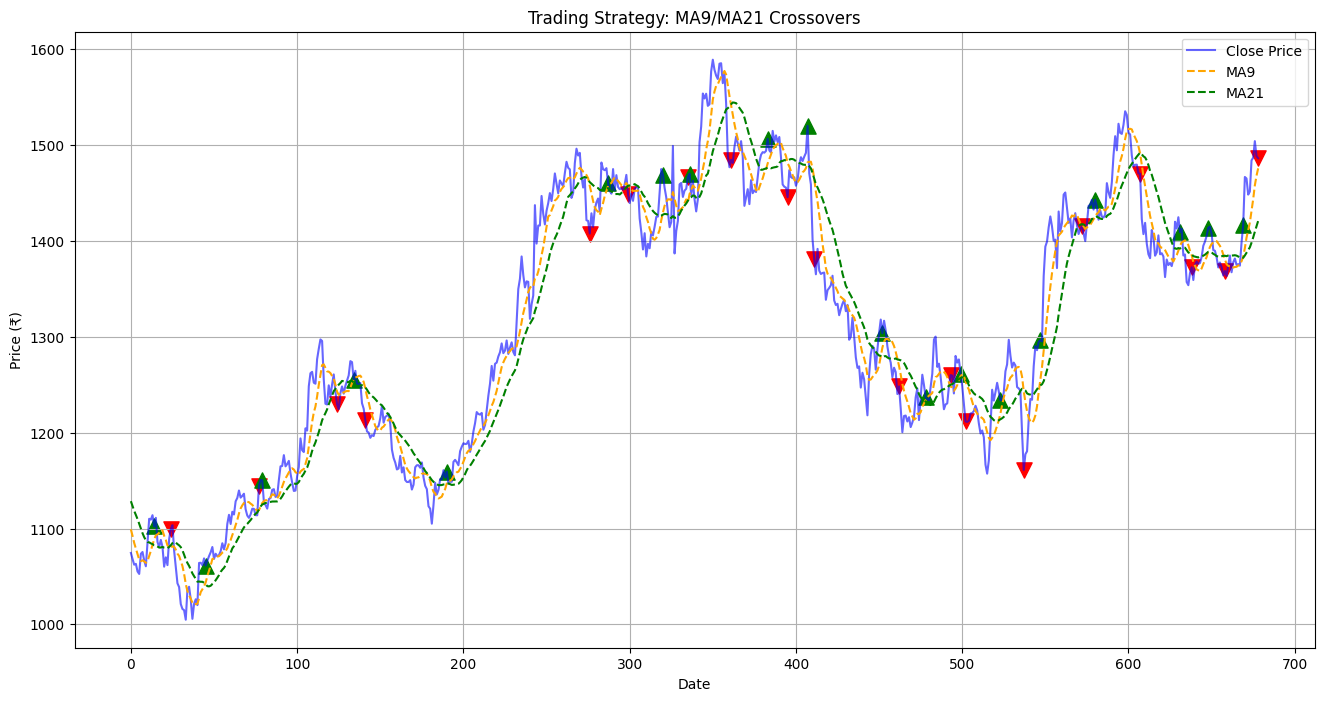

/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1345: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)


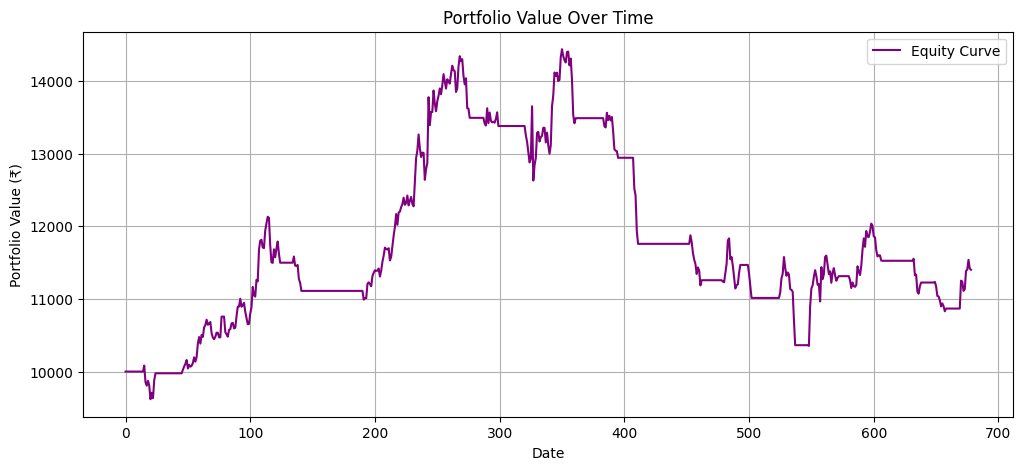

In [ ]:
# --- Simulate trading (all-in each trade) ---

INITIAL_CAPITAL = 10000.0  # Starting capital
cash = INITIAL_CAPITAL
shares = 0.0
equity_curve = []   # daily total equity
trades = []

# Ensure we have a 'date' column for plotting
df = df.copy()
if 'date' not in df.columns:
    df = df.reset_index().rename(columns={'index': 'date'})

# Main trading loop
for i in range(len(df)):
    price = float(df.loc[i, 'close'])
    sig = int(df.loc[i, 'Signal'])

    # BUY
    if sig == 1 and cash > 0:
        shares = cash / price
        cash = 0.0
        trades.append((df.loc[i, 'date'], 'BUY', price, shares))

    # SELL
    elif sig == -1 and shares > 0:
        cash = shares * price
        trades.append((df.loc[i, 'date'], 'SELL', price, shares))
        shares = 0.0

    # Record equity (cash + current holdings)
    equity = cash + (shares * price)
    equity_curve.append((df.loc[i, 'date'], equity))

# Final forced sell if still holding
if shares > 0:
    final_price = float(df['close'].iloc[-1])
    cash = shares * final_price
    trades.append((df['date'].iloc[-1], 'SELL_AT_END', final_price, shares))
    shares = 0.0
    equity_curve[-1] = (equity_curve[-1][0], cash)

# Convert to DataFrame
equity_df = pd.DataFrame(equity_curve, columns=['date', 'equity'])

# --- Results ---
final_value = float(equity_df['equity'].iloc[-1])
total_return = (final_value - INITIAL_CAPITAL) / INITIAL_CAPITAL * 100

print(f"\n💰 Final Portfolio Value: ₹{final_value:,.2f}")
print(f"📈 Total Return: {total_return:.2f}%")
print(f"📊 Number of Trades: {len(trades)}")

# --- Plot 1: Price with Buy/Sell Points ---
plt.figure(figsize=(16,8))
plt.plot(df['date'], df['close'], label='Close Price', color='blue', alpha=0.6)
plt.plot(df['date'], df['MA9'], label='MA9', color='orange', linestyle='--')
plt.plot(df['date'], df['MA21'], label='MA21', color='green', linestyle='--')

# Mark buy/sell points
for (d, action, p, s) in trades:
    if "BUY" in action:
        plt.scatter(d, p, color='green', marker='^', s=120)
    elif "SELL" in action:
        plt.scatter(d, p, color='red', marker='v', s=120)

plt.title("Trading Strategy: MA9/MA21 Crossovers")
plt.xlabel("Date")
plt.ylabel("Price (₹)")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot 2: Equity Curve ---
plt.figure(figsize=(12,5))
plt.plot(equity_df['date'], equity_df['equity'], color='purple', label='Equity Curve')
plt.title("Portfolio Value Over Time")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (₹)")
plt.legend()
plt.grid(True)
plt.show()


# 🧩 Case 3: Technical Indicators + ML Model

This model combines multiple indicators such as RSI, MACD, Bollinger Bands, and ATR  
with an LSTM model to predict the stock’s future closing price.

We also generate **Buy/Sell/Hold** signals using thresholds and backtest portfolio growth.



In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

TICKER = "RELIANCE.NS"
START = "2023-01-01"

# Fetch data
df = yf.download(TICKER, start=START)
df = df[['Open','High','Low','Close','Volume']]
df.rename(columns={'Close':'close','Open':'open','High':'high','Low':'low','Volume':'volume'}, inplace=True)
df.head()


/tmp/ipython-input-2572879803.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START)
[*********************100%***********************]  1 of 1 completed


Price,open,high,low,close,volume
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
Date,,,,,
2023-01-02,1164.066352,1177.304802,1163.244669,1175.889648,5316175
2023-01-03,1170.936659,1174.565828,1163.062148,1167.284668,7658932
2023-01-04,1167.261851,1169.110728,1147.632506,1149.709595,9264891
2023-01-05,1151.969076,1157.857903,1143.067373,1147.655151,13637099
2023-01-06,1153.407240,1163.130627,1149.595501,1158.086304,6349597


In [ ]:
def add_technical_indicators(df):
    """
    Add key technical indicators to the stock dataframe.
    df: dataframe with columns ['open','high','low','close','volume']
    """

    # Moving Averages
    df['MA20'] = df['close'].rolling(window=20).mean()
    df['MA50'] = df['close'].rolling(window=50).mean()
    df['MA100'] = df['close'].rolling(window=100).mean()

    # Relative Strength Index (RSI)
    delta = df['close'].diff()
    up = delta.clip(lower=0)
    down = -1*delta.clip(upper=0)
    roll_up = up.rolling(14).mean()
    roll_down = down.rolling(14).mean()
    RS = roll_up / roll_down
    df['RSI_14'] = 100 - (100 / (1 + RS))

    # Bollinger Bands (20-day)
    df['BB_Mid'] = df['close'].rolling(window=20).mean()
    df['BB_Std'] = df['close'].rolling(window=20).std()
    df['BB_High'] = df['BB_Mid'] + 2*df['BB_Std']
    df['BB_Low'] = df['BB_Mid'] - 2*df['BB_Std']
    df['BB_Width'] = df['BB_High'] - df['BB_Low']

    # MACD
    exp12 = df['close'].ewm(span=12, adjust=False).mean()
    exp26 = df['close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp12 - exp26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # ATR (14-day)
    df['H-L'] = df['high'] - df['low']
    df['H-C'] = abs(df['high'] - df['close'].shift(1))
    df['L-C'] = abs(df['low'] - df['close'].shift(1))
    df['TR'] = df[['H-L','H-C','L-C']].max(axis=1)
    df['ATR_14'] = df['TR'].rolling(14).mean()
    df.drop(['H-L','H-C','L-C','TR'], axis=1, inplace=True)

    # Drop rows with NaN due to rolling calculations
    df = df.dropna()

    return df

# Apply to your dataset
df = add_technical_indicators(df)
display(df.tail())


/tmp/ipython-input-3050946175.py:40: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H-L','H-C','L-C','TR'], axis=1, inplace=True)


Price,open,high,low,close,volume,MA20,MA50,MA100,RSI_14,BB_Mid,BB_Std,BB_High,BB_Low,BB_Width,MACD,MACD_Signal,ATR_14
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,
2025-10-27,1463.000000,1485.000000,1458.000000,1484.099976,14113867,1399.480011,1392.876008,1418.443385,77.648255,1399.480011,40.092395,1479.664800,1319.295222,160.369579,20.299169,9.434915,23.335720
2025-10-28,1484.099976,1492.000000,1477.599976,1486.900024,17631577,1404.945013,1395.072009,1419.134012,76.826068,1404.945013,44.192640,1493.330294,1316.559733,176.770562,23.327595,12.213451,22.871434
2025-10-29,1490.000000,1508.300049,1488.099976,1504.199951,11884745,1411.515009,1397.680007,1419.809391,85.962158,1411.515009,48.699804,1508.914616,1314.115401,194.799216,26.814503,15.133662,22.650007
2025-10-30,1500.000000,1503.099976,1484.000000,1488.500000,9318663,1417.740009,1399.816008,1420.316814,78.312043,1417.740009,50.239294,1518.218598,1317.261420,200.957178,27.988415,17.704612,23.192862
2025-10-31,1490.400024,1497.500000,1482.300049,1486.400024,8758053,1423.625012,1401.142009,1420.750447,77.026372,1423.625012,51.079068,1525.783148,1321.466876,204.316272,28.421671,19.848024,23.357143


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Select features for LSTM
features = ['close', 'MA20', 'MA50', 'MA100', 'RSI_14',
            'BB_High', 'BB_Low', 'BB_Width', 'MACD', 'MACD_Signal', 'ATR_14']

data_features = df[features].values

# Split into train and validation (same as before)
train_size = int(len(data_features)*0.8)
train_data = data_features[:train_size]
valid_data = data_features[train_size:]

# Scale features
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data)
scaled_valid = scaler.transform(valid_data)

# Function to create sequences
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])  # seq_length x num_features
        y.append(data[i, 0])  # Predict 'close' price
    return np.array(X), np.array(y)

x_train, y_train = create_sequences(scaled_train)
x_valid, y_valid = create_sequences(np.vstack([scaled_train[-60:], scaled_valid]))  # include last 60 days of train for continuity

print("x_train shape:", x_train.shape)  # (num_samples, 60, num_features)
print("y_train shape:", y_train.shape)


x_train shape: (420, 60, 11)
y_train shape: (420,)


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

lstm_model = Sequential()
lstm_model.add(LSTM(units=150, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=150))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))  # Predict close price

lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.summary()

# Train the model
lstm_model.fit(x_train, y_train, epochs=10, batch_size=16, verbose=2)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 150)        │        97,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,951 (1.06 MB)

 Trainable params: 277,951 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
27/27 - 11s - 413ms/step - loss: 0.0438
Epoch 2/10
27/27 - 9s - 335ms/step - loss: 0.0091
Epoch 3/10
27/27 - 5s - 183ms/step - loss: 0.0083
Epoch 4/10
27/27 - 3s - 129ms/step - loss: 0.0070
Epoch 5/10
27/27 - 6s - 229ms/step - loss: 0.0063
Epoch 6/10
27/27 - 4s - 145ms/step - loss: 0.0054
Epoch 7/10
27/27 - 3s - 127ms/step - loss: 0.0057
Epoch 8/10
27/27 - 3s - 127ms/step - loss: 0.0072
Epoch 9/10
27/27 - 5s - 185ms/step - loss: 0.0049
Epoch 10/10
27/27 - 3s - 125ms/step - loss: 0.0053


In [ ]:
# Predict closing prices for validation set
predicted_scaled = lstm_model.predict(x_valid)
predicted_close = scaler.inverse_transform(
    np.hstack([predicted_scaled, np.zeros((predicted_scaled.shape[0], scaled_valid.shape[1]-1))])
)[:,0]  # only take 'close' column


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


In [ ]:
# Correct actual_close length
actual_close = df['close'].values[train_size:]  # validation data
actual_close = actual_close[:len(predicted_close)]  # match predicted length


### 📈 Model Performance and Backtest Results

We evaluate model accuracy using **MSE, RMSE, MAPE, and Directional Accuracy**,  
then simulate a trading portfolio based on the model’s predicted signals.


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

mse = mean_squared_error(actual_close, predicted_close)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(actual_close, predicted_close)

# Directional Accuracy
direction_actual = np.sign(np.diff(actual_close.ravel()))
direction_pred = np.sign(np.diff(predicted_close.ravel()))


# Ensure arrays have the same length before comparison
min_len = min(len(direction_actual), len(direction_pred))
direction_actual = direction_actual[:min_len]
direction_pred = direction_pred[:min_len]


directional_accuracy = np.mean(direction_actual == direction_pred) * 100

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}%")
print(f"MAPE: {mape*100:.2f}%")
print(f"Directional Accuracy: {directional_accuracy:.2f}%")

MSE: 1912.02
RMSE: 43.73%
MAPE: 2.56%
Directional Accuracy: 48.74%


In [ ]:
# Threshold for price movement (0.5%)
threshold = 0.005

# Extract MACD and RSI for the validation period
macd_valid = df['MACD'].values[train_size:]
rsi_valid = df['RSI_14'].values[train_size:]

signals = []
# Ensure all arrays have the same length for iteration
min_len_signal = min(len(actual_close), len(predicted_close), len(macd_valid), len(rsi_valid))

for i in range(min_len_signal):
    today_close = actual_close[i]
    pred_close = predicted_close[i]

    # MACD and RSI as filters (optional)
    macd = macd_valid[i]
    rsi = rsi_valid[i]

    if pred_close > today_close * (1 + threshold) and macd > 0 and rsi < 70:
        signals.append("Buy")
    elif pred_close < today_close * (1 - threshold) and macd < 0 and rsi > 30:
        signals.append("Sell")
    else:
        signals.append("Hold")

# Add signals to a DataFrame for visualization
signal_df = pd.DataFrame({
    "Actual_Close": actual_close[:min_len_signal].ravel(),
    "Predicted_Close": predicted_close[:min_len_signal].ravel(),
    "MACD": macd_valid[:min_len_signal].ravel(),
    "RSI": rsi_valid[:min_len_signal].ravel(),
    "Signal": signals
})

display(signal_df.tail(20))

,Actual_Close,Predicted_Close,MACD,RSI,Signal
100,1363.400024,1324.469285,-6.655691,32.713320,Sell
101,1375.000000,1318.136432,-6.372278,37.689908,Sell
102,1384.800049,1315.122758,-5.295842,39.999976,Sell
103,1367.400024,1315.717065,-5.780166,29.174095,Hold
104,1377.800049,1315.040845,-5.264119,34.577116,Sell
105,1381.699951,1316.483160,-4.488715,39.007647,Sell
106,1375.000000,1320.226979,-4.364521,42.696619,Sell
107,1375.900024,1324.972649,-4.145683,43.498572,Sell
108,1374.300049,1329.583201,-4.054617,45.722726,Sell
109,1398.300049,1333.642798,-2.022534,61.251123,Sell


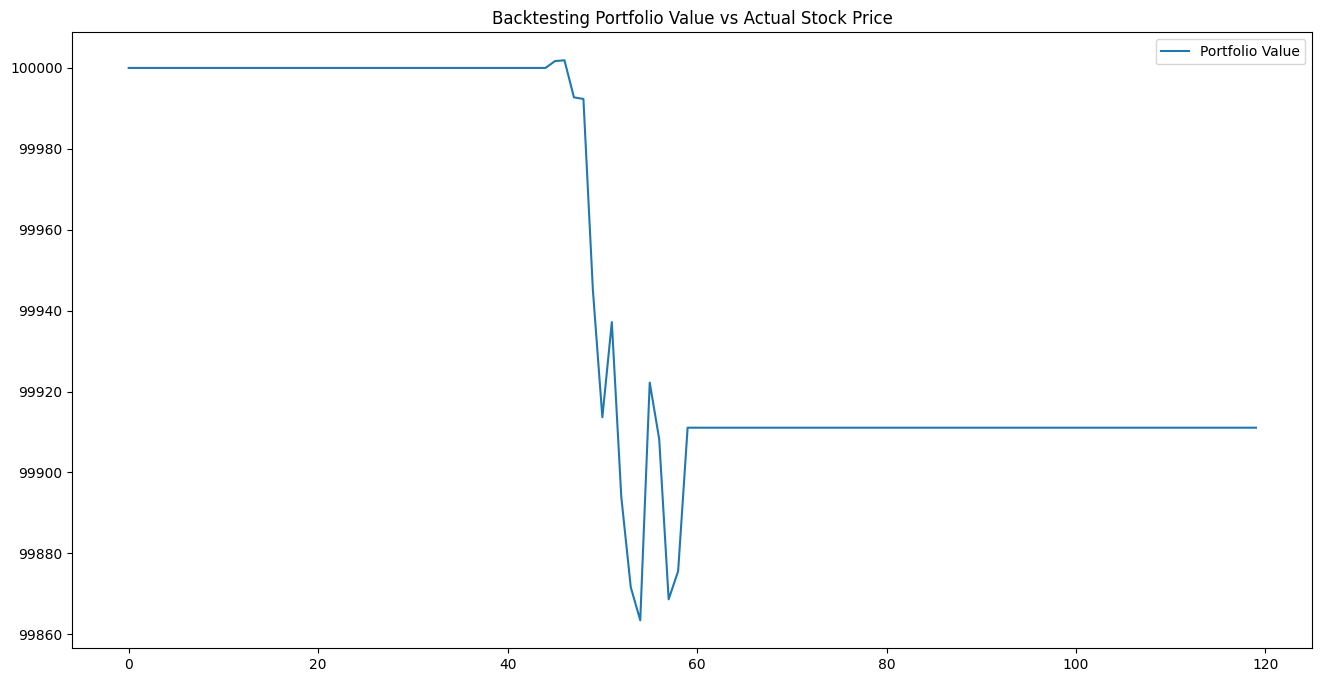

Initial Cash: $100000
Final Portfolio Value: $99911.06


In [ ]:
initial_cash = 100000
cash = initial_cash
position = 0  # number of shares
portfolio_value = []

for i in range(len(signal_df)):
    price = signal_df['Actual_Close'].iloc[i]
    signal = signal_df['Signal'].iloc[i]

    # Buy
    if signal == "Buy" and cash >= price:
        position += 1
        cash -= price

    # Sell
    elif signal == "Sell" and position > 0:
        cash += position * price
        position = 0

    # Portfolio value = cash + current stock position value
    portfolio_value.append(cash + position * price)

signal_df['Portfolio_Value'] = portfolio_value

plt.figure(figsize=(16,8))
plt.plot(signal_df['Portfolio_Value'], label='Portfolio Value')
plt.title("Backtesting Portfolio Value vs Actual Stock Price")
plt.legend()
plt.show()

print(f"Initial Cash: ${initial_cash}")
print(f"Final Portfolio Value: ${portfolio_value[-1]:.2f}")


# 📊 Summary & Insights

| Case | Approach | Description | Outcome |
|------|-----------|--------------|----------|
| 1️⃣ | LSTM | Next-day price prediction | Good prediction trend but volatile accuracy |
| 2️⃣ | MA Crossover | Traditional technical strategy | Consistent entry-exit points |
| 3️⃣ | ML + Indicators | Combination of indicators + LSTM | Low directional accuracy but rich insights |

---

## 🧠 Key Takeaways
- LSTM captures trends but struggles with daily noise.
- MA crossover provides smoother, rule-based strategies.
- Combining ML + indicators improves context but needs tuning.

---

## 🔮 Future Improvements
- Use more data (5+ years) for better generalization  
- Experiment with GRU or Transformer-based models  
- Add sentiment data from news or Twitter  
- Use reinforcement learning for adaptive trading signals

---
